In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import random

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from wandb.keras import WandbCallback

In [4]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [61]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [62]:
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [63]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [64]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

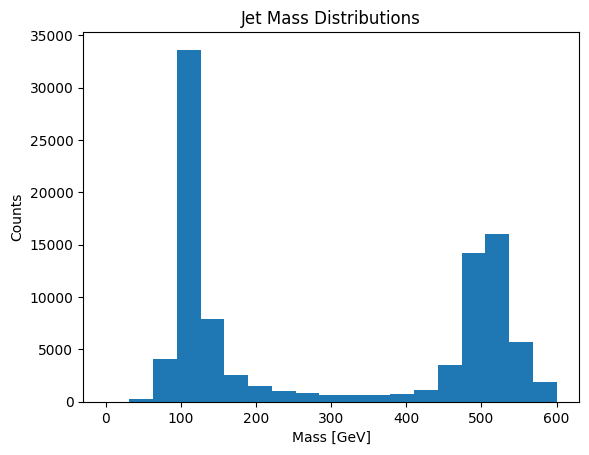

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [10]:
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq.txt")

jets = []
count = 0
for line in file:
    if count == 2:
        break
    print(line)
    jets += [line.split("J")[1].split("P")[0].split()]
    count+=1

0 0 J 1788.55 -0.300279 -2.51608 130.279 0 0.0289343 0.0153102 0.0126833 0.010346 0.00825964  P 4.64413 -0.377384 3.00207  P 2.47947 -0.425799 3.02334  P 2.68613 -0.39458 -2.608  P 5.84707 -0.404504 -2.54133  P 24.9416 -0.408844 -2.52053  P 6.58412 -0.387347 -2.54543  P 13.1517 -0.350432 -2.59254  P 13.7381 -0.300859 -2.52212  P 4.55674 -0.286343 -2.52545  P 517.142 -0.286492 -2.50205 

0 1 J 1643.32 -0.173344 0.717105 95.8961 0 0.0424313 0.0221081 0.0140335 0.0108518 0.00877299  P 1.75001 -0.530883 0.585762  P 2.74298 -0.297844 0.694373  P 5.4756 -0.195946 0.630677  P 7.35714 -0.200437 0.647468  P 9.16487 -0.119969 0.704896  P 5.77878 -0.125155 0.709119  P 6.37682 -0.141306 0.773328  P 8.23397 -0.155549 0.732862  P 29.6409 -0.186092 0.763671  P 2.24246 -0.170876 0.729569  P 245.519 -0.180535 0.735561 



In [56]:
jets

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964'],
 ['1643.32',
  '-0.173344',
  '0.717105',
  '95.8961',
  '0',
  '0.0424313',
  '0.0221081',
  '0.0140335',
  '0.0108518',
  '0.00877299']]

In [31]:
ljet = [jets[2*n] for n in range(int(len(jets)/2))]
sjet = [jets[2*n+1] for n in range(int(len(jets)/2))]

In [32]:
ljet

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964']]

In [11]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [12]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [13]:
m = 100
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(m)+"_"+str(m)+".txt")
jets_m_m = []
for line in file:
    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
    pass
computemjj_txt(jets_m_m)[0]

3674.182176987098

In [44]:
len(jets_m_m)

180286

In [5]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array", x_array)

In [6]:
#reads in data 
x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [7]:
x[0,0]

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752],
       ...,
       [-0.8137767 , -0.68498134, -0.48486568, -1.80944097],
       [-0.60554108, -0.3927861 ,  1.66516101, -0.46855806],
       [-1.03992653,  0.32502271,  1.51100575, -1.56040698]])

In [8]:
x_vals_100 = np.concatenate([x[0,0],x[1,1]])
y_vals_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_vals_100, y_vals_100, test_size=0.5)

In [249]:
x_vals_100

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752],
       ...,
       [-0.72849452, -1.20127827, -1.46586875, -0.17525045],
       [-0.71564546, -1.27923195, -1.13014702,  0.1427768 ],
       [-0.69956274, -1.30933612, -0.96529716, -0.55303517]])

In [9]:
#initializies wandb config
if not wandb.run:
    wandb.init(
        # set the wandb project where this run will be logged
        project="Anomaly",
        group="Dedicated",
        entity='gup-singh',

        config={
            "layer_1": 256,
            "activation_1": "relu",
            "layer_2": 256,
            "activation_2": "relu",
            "layer_3": 256,
            "activation_3": "relu",
            "output_layer": 1,
            "output_activation": "sigmoid",
            "optimizer": "adam",
            "loss": "binary_crossentropy",
            "metric": "accuracy",
            "epoch": 20,
            "batch_size": 1024
        }
    )

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh. Use `wandb login --relogin` to force relogin


In [610]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        
        self.dense2 = Dense(config.layer_2, activation=config.activation_2)
        
        self.dense3 = Dense(config.layer_3, activation=config.activation_3)
        
        self.dense4 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        
        x = self.dense2(x)
        
        x = self.dense3(x)
        
        x = self.dense4(x)
        
        return x

In [611]:
model = MyModel()
model.build(input_shape=(None, X_train_100.shape[1]))
model.compile(loss=config.loss, optimizer=config.optimizer, metrics=["accuracy"])
model.summary()

Model: "my_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_947 (Dense)           multiple                  1280      
                                                                 
 dense_948 (Dense)           multiple                  65792     
                                                                 
 dense_949 (Dense)           multiple                  65792     
                                                                 
 dense_950 (Dense)           multiple                  257       
                                                                 
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
_________________________________________________________________


In [12]:
myhistory = model.fit(x_vals_100, y_vals_100, epochs=config.epoch, validation_data=(X_val_100, Y_val_100),batch_size=config.batch_size, callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
 60/193 [========>.....................] - ETA: 0s - loss: 0.3233 - accuracy: 0.8690

2023-09-25 12:44:24.861565: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


179/193 [==========================>...] - ETA: 0s - loss: 0.2487 - accuracy: 0.8995

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.0s


193/193 [==============================] - 2s 6ms/step - loss: 0.2443 - accuracy: 0.9014 - val_loss: 0.1867 - val_accuracy: 0.9259
Epoch 2/20
173/193 [=========================>....] - ETA: 0s - loss: 0.1821 - accuracy: 0.9267

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.1s


193/193 [==============================] - 1s 5ms/step - loss: 0.1815 - accuracy: 0.9271 - val_loss: 0.1830 - val_accuracy: 0.9262
Epoch 3/20
162/193 [========================>.....] - ETA: 0s - loss: 0.1797 - accuracy: 0.9273

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1794 - accuracy: 0.9277 - val_loss: 0.1788 - val_accuracy: 0.9281
Epoch 4/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1785 - accuracy: 0.9283 - val_loss: 0.1791 - val_accuracy: 0.9278
Epoch 5/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9281 - val_loss: 0.1818 - val_accuracy: 0.9261
Epoch 6/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9288 - val_loss: 0.1816 - val_accuracy: 0.9269
Epoch 7/20
176/193 [==========================>...] - ETA: 0s - loss: 0.1775 - accuracy: 0.9284

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1776 - accuracy: 0.9284 - val_loss: 0.1775 - val_accuracy: 0.9284
Epoch 8/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.9289 - val_loss: 0.1781 - val_accuracy: 0.9279
Epoch 9/20
165/193 [========================>.....] - ETA: 0s - loss: 0.1756 - accuracy: 0.9293

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.1s


193/193 [==============================] - 1s 5ms/step - loss: 0.1762 - accuracy: 0.9291 - val_loss: 0.1769 - val_accuracy: 0.9285
Epoch 10/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.9292 - val_loss: 0.1772 - val_accuracy: 0.9282
Epoch 11/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.9294 - val_loss: 0.1806 - val_accuracy: 0.9273
Epoch 12/20
171/193 [=========================>....] - ETA: 0s - loss: 0.1757 - accuracy: 0.9292

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1757 - accuracy: 0.9290 - val_loss: 0.1756 - val_accuracy: 0.9288
Epoch 13/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.9289 - val_loss: 0.1771 - val_accuracy: 0.9283
Epoch 14/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1754 - accuracy: 0.9293 - val_loss: 0.1767 - val_accuracy: 0.9285
Epoch 15/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.9293 - val_loss: 0.1764 - val_accuracy: 0.9288
Epoch 16/20
176/193 [==========================>...] - ETA: 0s - loss: 0.1747 - accuracy: 0.9294

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1747 - accuracy: 0.9293 - val_loss: 0.1755 - val_accuracy: 0.9285
Epoch 17/20
168/193 [=========================>....] - ETA: 0s - loss: 0.1739 - accuracy: 0.9296

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1745 - accuracy: 0.9293 - val_loss: 0.1751 - val_accuracy: 0.9294
Epoch 18/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1743 - accuracy: 0.9294 - val_loss: 0.1769 - val_accuracy: 0.9286
Epoch 19/20
165/193 [========================>.....] - ETA: 0s - loss: 0.1740 - accuracy: 0.9294

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230925_124419-2d7tbm98/files/model-best)... Done. 0.1s


193/193 [==============================] - 1s 5ms/step - loss: 0.1736 - accuracy: 0.9296 - val_loss: 0.1747 - val_accuracy: 0.9291
Epoch 20/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1737 - accuracy: 0.9301 - val_loss: 0.1749 - val_accuracy: 0.9293


In [13]:
wandb.finish()

accuracy,▁▇▇█████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▅▁▃▆▅▆▆▄▇▆▆▇▆█▆▇█
val_loss,█▆▃▄▅▅▃▃▂▂▄▂▂▂▂▁▁▂▁▁
accuracy,0.93007
best_epoch,18
best_val_loss,0.17475
epoch,19
loss,0.1737
val_accuracy,0.92929


Analysis of Models begins here

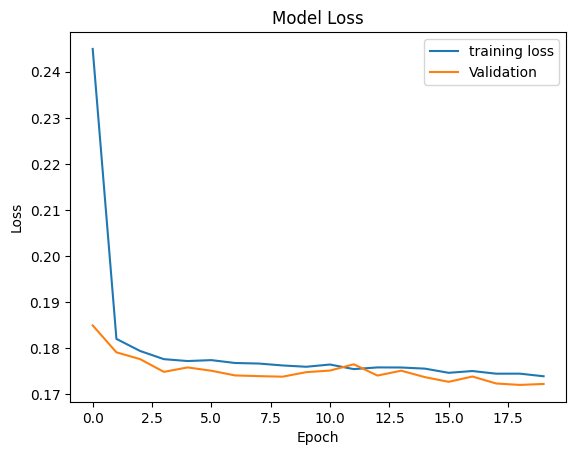

In [255]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [256]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 645us/step


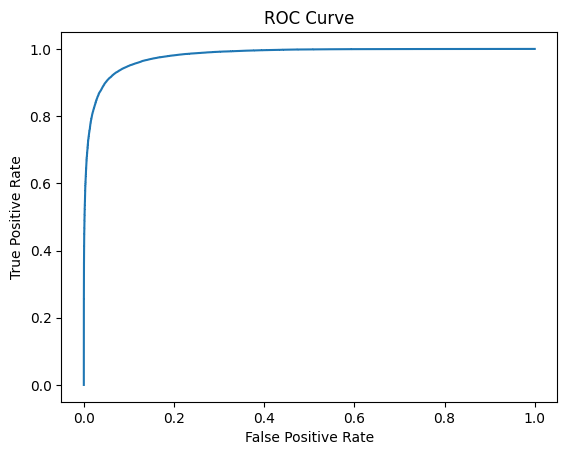

In [257]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [258]:
def pred_accuracy(y_test, predictions):

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_model = pred_accuracy(Y_val_100, list(preds_100))
print("Accuracy of Model: {:.2%}".format(accuracy_model))

Accuracy of Model: 93.07%


In [33]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.ones(len(x_aug_0)),np.zeros(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.ones(len(x_aug_0)),np.zeros(len(x_aug_m))])

    np.save("x_vals_all",x_vals_all)
    np.save("y_vals_all",y_vals_all)

In [97]:
x_aug_m

array([[-0.72413866,  1.69355063,  1.11205286, -1.87386705,  6.        ,
         6.        ],
       [ 0.80799657,  0.66064736, -0.59943671, -2.09319001,  6.        ,
         6.        ],
       [ 2.17499885, -1.1884174 , -1.60538663, -1.95211824,  6.        ,
         6.        ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [ ]:
#rewrite cell above to understand
x_valls_all = []
y_valls_all = []

for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        x_aug_0 = np.append(np.append())

In [66]:
test = np.append([[1, 2],[3, 4]], [[5, 6]], 0)
m1 = 0.5
m2 = 0.5
m1 = m1 * np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
m2 = m2 * np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1])
print(np.reshape(np.ones(len(x[0,0])),[len(x[0,0]), 1]))
print(m2)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]


In [14]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [15]:
np.shape(x_vals_all)

(27188652, 6)

In [16]:
x_vals_all

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [17]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [372]:
len(X_train_all)

13594326

In [608]:
if not wandb.run:
    wandb.init(
        # set the wandb project where this run will be logged
        project="Anomaly",
        group="Parametrized",
        entity='gup-singh',

        config={
            "layer_1": 256,
            "activation_1": "relu",
            "layer_2": 256,
            "activation_2": "relu",
            "layer_3": 256,
            "activation_3": "relu",
            "output_layer": 1,
            "output_activation": "sigmoid",
            "optimizer": "adam",
            "loss": "binary_crossentropy",
            "metric": "accuracy",
            "epoch": 20,
            "batch_size": 1024
        }
    )

config = wandb.config

In [609]:
model_all = MyModel()
model_all.build(input_shape=(None, X_train_all.shape[1]))
model_all.compile(loss=config.loss, optimizer=config.optimizer, metrics=["accuracy"])
model_all.summary()

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_943 (Dense)           multiple                  1792      
                                                                 
 dense_944 (Dense)           multiple                  65792     
                                                                 
 dense_945 (Dense)           multiple                  65792     
                                                                 
 dense_946 (Dense)           multiple                  257       
                                                                 
Total params: 133,633
Trainable params: 133,633
Non-trainable params: 0
_________________________________________________________________


In [612]:
myhistory_all = model_all.fit(x_vals_all, y_vals_all, epochs=config.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config.batch_size*5, callbacks = [WandbCallback()])

Epoch 1/20
5301/5311 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9326

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.1s


5311/5311 [==============================] - 12s 2ms/step - loss: 0.1717 - accuracy: 0.9326 - val_loss: 0.1652 - val_accuracy: 0.9350
Epoch 2/20
5306/5311 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9362

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 12s 2ms/step - loss: 0.1626 - accuracy: 0.9362 - val_loss: 0.1619 - val_accuracy: 0.9365
Epoch 3/20
5280/5311 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9365

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1619 - accuracy: 0.9365 - val_loss: 0.1613 - val_accuracy: 0.9367
Epoch 4/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1614 - accuracy: 0.9367 - val_loss: 0.1614 - val_accuracy: 0.9366
Epoch 5/20
5299/5311 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9368

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1611 - accuracy: 0.9368 - val_loss: 0.1609 - val_accuracy: 0.9369
Epoch 6/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1609 - accuracy: 0.9368 - val_loss: 0.1610 - val_accuracy: 0.9368
Epoch 7/20
5281/5311 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9369

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1607 - accuracy: 0.9369 - val_loss: 0.1601 - val_accuracy: 0.9372
Epoch 8/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1606 - accuracy: 0.9370 - val_loss: 0.1606 - val_accuracy: 0.9370
Epoch 9/20
5309/5311 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9370

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1605 - accuracy: 0.9370 - val_loss: 0.1600 - val_accuracy: 0.9372
Epoch 10/20
5296/5311 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9370

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1604 - accuracy: 0.9370 - val_loss: 0.1598 - val_accuracy: 0.9373
Epoch 11/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1603 - accuracy: 0.9371 - val_loss: 0.1603 - val_accuracy: 0.9370
Epoch 12/20
5281/5311 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9371

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1602 - accuracy: 0.9371 - val_loss: 0.1597 - val_accuracy: 0.9373
Epoch 13/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1601 - accuracy: 0.9371 - val_loss: 0.1600 - val_accuracy: 0.9372
Epoch 14/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1601 - accuracy: 0.9372 - val_loss: 0.1599 - val_accuracy: 0.9373
Epoch 15/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1600 - accuracy: 0.9372 - val_loss: 0.1602 - val_accuracy: 0.9371
Epoch 16/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1599 - accuracy: 0.9372 - val_loss: 0.1597 - val_accuracy: 0.9373
Epoch 17/20
5301/5311 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9372

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1599 - accuracy: 0.9372 - val_loss: 0.1595 - val_accuracy: 0.9374
Epoch 18/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1598 - accuracy: 0.9373 - val_loss: 0.1595 - val_accuracy: 0.9374
Epoch 19/20
5302/5311 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9373

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1597 - accuracy: 0.9373 - val_loss: 0.1592 - val_accuracy: 0.9375
Epoch 20/20
5292/5311 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9373

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230926_204540-2hm0oz0y/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 10s 2ms/step - loss: 0.1597 - accuracy: 0.9373 - val_loss: 0.1592 - val_accuracy: 0.9375


In [613]:
wandb.finish()

accuracy,▁▆▇▇▇▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▆▆▇▆▇▇▇▇▇▇▇█████
val_loss,█▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
accuracy,0.93732
best_epoch,19
best_val_loss,0.15921
epoch,19
loss,0.15966
val_accuracy,0.93747


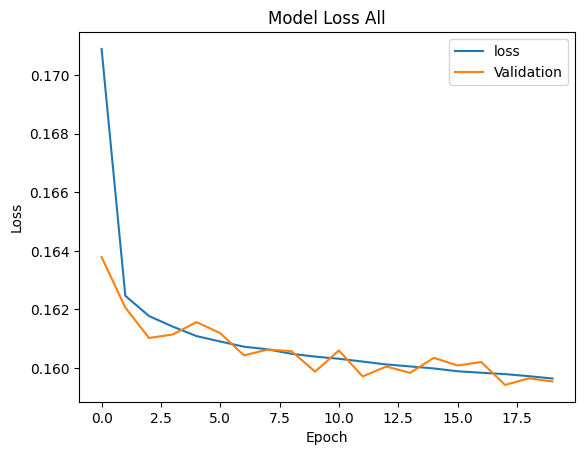

In [91]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [88]:
preds_all = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1.,1.],axis=1)==1],batch_size=1000)

99/99 [==============================] - 0s 878us/step


In [89]:
fpr_all, tpr_all, _ = roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1.,1.],axis=1)==1], preds_all)

/tmp/ipykernel_1951855/2571013946.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100,1./fpr_100,label="dedicated_100")
/tmp/ipykernel_1951855/2571013946.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all,1./fpr_all,label="parameterized")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated vs Parametrized')

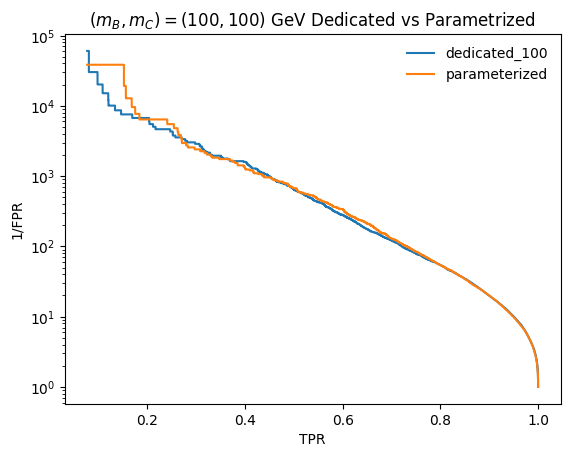

In [92]:
plt.plot(tpr_100,1./fpr_100,label="dedicated_100")
plt.plot(tpr_all,1./fpr_all,label="parameterized")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated vs Parametrized")

In [60]:
#written by Nachman

# for l in model_all.layers:
#     l.trainable=False

# inputs_hold = tf.keras.Input(shape=(1,))
# simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(2.))(inputs_hold)
# model3 = Model(inputs = inputs_hold, outputs = simple_model)

# inputs_hold2 = tf.keras.Input(shape=(1,))
# simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(3.))(inputs_hold2)
# model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

# inputs = tf.keras.Input(shape=(4,))
# inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
# hidden_layer_1 = model_all(inputs2)
# model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
# model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [22]:
#rewrite cell above to understand/improve

#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

#creates models with single node and arbitrary weight
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [23]:
model_all2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.ones_like_1 (TFOpLambda)    (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['tf.ones_like[0][0]']           
 ingOpLambda)                                                                               

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [25]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 2.9198 - val_loss: 2.2686
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.2027 - val_loss: 2.1457
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.1269 - val_loss: 2.1030
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.0928 - val_loss: 2.0766
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.0679 - val_loss: 2.0528
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.0439 - val_loss: 2.0273
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.0183 - val_loss: 2.0014
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 1.9936 - val_loss: 1.9785
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 1.9734 - val_loss: 1.9606
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 1.9591 - val_loss: 1.9493

In [31]:
class SingleWeightLayer(tf.keras.layers.Layer):
    def __init__(self, initial_value=1, **kwargs):
        super(SingleWeightLayer, self).__init__(**kwargs)
        self.initial_value = initial_value
        
    def build(self, input_shape):
        self.weight = self.add_weight(shape=(1,), initializer=tf.keras.initializers.Constant(self.initial_value), trainable=True)
    
    def call(self, inputs):            
        output = inputs * self.weight
        return tf.nn.relu(output)

In [26]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(2.)
            model32 = createSimpleModel(3.)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.ones(len(x[0,0])),np.zeros(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(x_vals_[:,0:4], y_vals_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

Epoch 1/10
192/192 [==============================] - 1s 3ms/step - loss: 1.9636 - val_loss: 0.7950
Epoch 2/10
192/192 [==============================] - 0s 2ms/step - loss: 0.7421 - val_loss: 0.7060
Epoch 3/10
192/192 [==============================] - 0s 2ms/step - loss: 0.6813 - val_loss: 0.6601
Epoch 4/10
192/192 [==============================] - 0s 2ms/step - loss: 0.6411 - val_loss: 0.6263
Epoch 5/10
192/192 [==============================] - 0s 2ms/step - loss: 0.6147 - val_loss: 0.6062
Epoch 6/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5993 - val_loss: 0.5947
Epoch 7/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5899 - val_loss: 0.5871
Epoch 8/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5836 - val_loss: 0.5821
Epoch 9/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5793 - val_loss: 0.5789
Epoch 10/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5765 - val_loss: 0.5764

In [27]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass
print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.49042767 9.830067  ]
[0.5 1. ] [0.88938004 9.238634  ]
[0.5 1.5] [1.4304806 9.517697 ]
[0.5 2. ] [1.9689283 9.606061 ]
[0.5 2.5] [2.4731803 2.60734  ]
[0.5 3. ] [2.9433212 3.1263187]
[0.5 3.5] [3.4188526 3.6357832]
[0.5 4. ] [3.8713343 4.1940656]
[0.5 4.5] [4.3091354 4.700434 ]
[0.5 5. ] [4.765122  5.1791496]
[0.5 5.5] [5.222106  5.6245484]
[0.5 6. ] [5.6688843 6.0374393]
[1.  0.5] [0.87079334 9.246256  ]
[1. 1.] [0.9875063 9.034551 ]
[1.  1.5] [ 1.0557623 10.506565 ]
[1. 2.] [1.9337032 9.006684 ]
[1.  2.5] [2.4186785 2.554087 ]
[1.5 0.5] [1.4414834 9.489062 ]
[1.5 1. ] [ 1.0541543 10.506485 ]
[2.  0.5] [1.9817356 9.547328 ]
[2. 1.] [1.9218352 8.973688 ]
[2.5 0.5] [2.4618433 2.6016176]
[2.5 1. ] [2.4148767 2.5469017]
[3.  0.5] [2.9418948 3.1273167]
[3.5 0.5] [3.4066985 3.632552 ]
[4.  0.5] [3.8819275 4.1506495]
[4.5 0.5] [4.355761  4.6727653]
[5.  0.5] [4.789882  5.1517525]
[5.5 0.5] [5.2717957 5.6144223]
[6.  0.5] [5.778035  5.9819303]
found both: 0.7916666666666666
found

In [761]:
sig_list = []
weight_list1 = []
weight_list2 = []
weight_list3 = []

epsilon = tf.constant(1e-6)

for sigfrac in np.logspace(-2,2,20):
    #sigfrac = 0.1
    print(sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    model3 = createSimpleModel(2)
    model32 = createSimpleModel(3)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1/ (1.- hidden_layer_1 + epsilon)
    #LLR_xs = 1.+sigfrac*LLR
    mu = model33(tf.ones_like(inputs)[:,0])
    LLR_xs = 1. + mu*LLR - mu
    ws = (LLR_xs)/ (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    #create ws data set
    m1 = 5.5
    m2 = 4.5

    #background
    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    #signal = x[m1, m2][test_signal_length:test_signal_length + int(.1*len(x[m1, m2]))]
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*test_background)]

    #[reference (1), data_background (1), signal(0)]
    x_vals_ = np.concatenate([x[0,0][test_background:], signal])
    y_vals_ = np.concatenate([np.ones(train_reference), np.ones(train_background + 1), np.zeros(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    trainble_weight1 = model_all2.trainable_weights[0].numpy()[0][0]
    trainble_weight2 = model_all2.trainable_weights[1].numpy()[0][0]
    trainble_weight3 = model_all2.trainable_weights[2].numpy()[0][0]

    print(m1,m2,trainble_weight1,trainble_weight2)

    sig_list+=[sigfrac]
    weight_list1+=[trainble_weight1]
    weight_list2+=[trainble_weight2]
    weight_list3+=[trainble_weight3]
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))

0.01
Epoch 1/20
30/30 [==============================] - 1s 8ms/step - loss: 0.1216 - val_loss: 0.1162
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1059 - val_loss: 0.1042
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0990 - val_loss: 0.1001
Epoch 4/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0955 - val_loss: 0.0964
Epoch 5/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0929 - val_loss: 0.0931
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0910 - val_loss: 0.0909
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.0893 - val_loss: 0.0888
Epoch 8/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0874 - val_loss: 0.0867
Epoch 9/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0852 - val_loss: 0.0842
Epoch 10/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0833 - val_loss: 0.0819
Epoch 11/20
30

In [747]:
scores = model_all2.predict(np.concatenate([x[0,0][:test_background],x[m1,m2][:test_signal_length]]), batch_size=1024)

95/95 [==============================] - 0s 709us/step


In [756]:
np.shape(x_vals_)

(89687, 4)

In [752]:
scores

array([[0.99738604],
       [0.9999458 ],
       [0.99393106],
       ...,
       [0.00940472],
       [0.00762604],
       [0.00703259]], dtype=float32)

(0.0, 600.0)

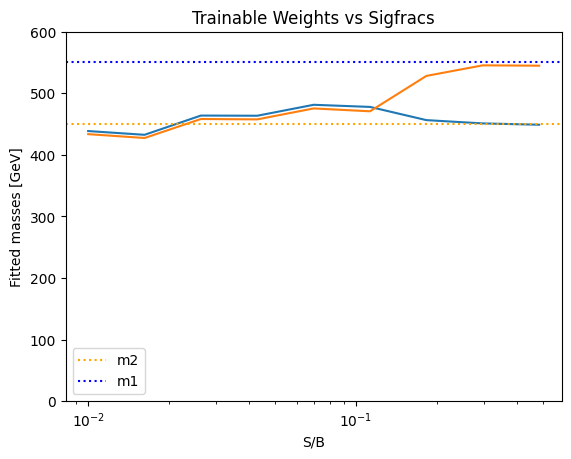

In [762]:
plt.plot(sig_list,np.array(weight_list1)*100)
plt.plot(sig_list,np.array(weight_list2)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.axhline(m2*100,ls=":",color='orange', label = "m2")
plt.axhline(m1*100,ls=":",color='blue', label = "m1")
plt.legend()
plt.title("Trainable Weights vs Sigfracs")
plt.ylim([0,600])

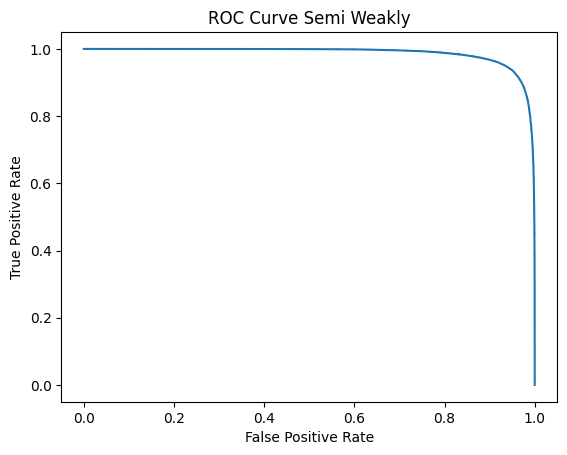

In [753]:
fpr, tpr, thresholds = roc_curve(y, scores)
plt.plot(fpr, 1-tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Semi Weakly')
plt.show()